In [1]:
import sys,os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data.mimic.semi_synthetic_pipeline import MIMICSemiSyntheticDataPipeline
import omegaconf
from hydra.utils import instantiate, get_original_cwd
config_path = '../config/dataset/mimic_synthetic_debug.yaml'

c:\Users\mhr_k\miniconda3\envs\R-learner\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = omegaconf.OmegaConf.load(config_path)
args.dataset.seed = 2026
#initialize the pipeline
data_pipeline = instantiate(args.dataset)

c:\Users\mhr_k\OneDrive\Documents\Thesis\Neural-R-Learner\src\data\mimic\load_data.py:234: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_vitals = all_vitals.fillna(method='ffill')
c:\Users\mhr_k\OneDrive\Documents\Thesis\Neural-R-Learner\src\data\mimic\load_data.py:235: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_vitals = all_vitals.fillna(method='bfill')
100%|██████████| 20/20 [00:02<00:00,  9.17it/s]
c:\Users\mhr_k\OneDrive\Documents\Thesis\Neural-R-Learner\src\data\mimic\semi_synthetic_pipeline.py:120: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  self.all_vitals = self.all_vitals.uns

In [3]:
import numpy as np
T_intv_disc, T_intv_cont = np.ones((3, 2)), None
T_base_disc, T_base_cont = np.zeros((3, 2)), None
gt_te = data_pipeline.compute_treatment_effect('test', T_intv_disc, T_intv_cont, T_base_disc, T_base_cont)

100%|██████████| 4/4 [00:00<00:00, 26.85it/s]


In [4]:
data_pipeline.test_index
patient_idxs = data_pipeline.test_index
X_dynamic = data_pipeline.vitals_np[patient_idxs]
#multiplier = np.flip(data_pipeline.true_effect_hetero_multiplier, axis = 0)
multiplier = data_pipeline.true_effect_hetero_multiplier
coeffs = [np.array(treatment['scale_function']['coefficients']) for treatment in args.dataset.synth_treatments_list]
types = [treatment['scale_function']['type'] for treatment in args.dataset.synth_treatments_list]
kappas = []
for i in range(len(types)):
    if types[i] == 'identity':
        kappas.append(lambda x: np.ones(x.shape[:-1]))
    elif types[i] == 'tanh':
        kappas.append((lambda x: np.tanh(np.dot(x, coeffs[i])) + 1))
max_active_index = data_pipeline.active_entries[patient_idxs, :].sum(axis = 1)
ind_true_effect = np.zeros((len(patient_idxs), data_pipeline.sequence_length - data_pipeline.n_periods + 1, 
                            data_pipeline.n_periods, data_pipeline.n_treatments))
for i, treatment in enumerate(data_pipeline.synthetic_treatments):
    conf_vars = treatment.confounding_vars
    conf_vars_idx = [data_pipeline.vital_cols.index(var) for var in conf_vars]
    kappa_x = kappas[i](X_dynamic[:, :, conf_vars_idx])
    for t in range(data_pipeline.sequence_length - data_pipeline.n_periods + 1):
        for p in range(data_pipeline.n_periods):
            ind_true_effect[:, t, p, i] = kappa_x[:, t + p]
expanded_multiplier = np.expand_dims(np.expand_dims(multiplier, axis = 0), axis = 0)
ind_true_effect = ind_true_effect * expanded_multiplier


c:\Users\mhr_k\OneDrive\Documents\Thesis\Neural-R-Learner\src\models\utils.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best")


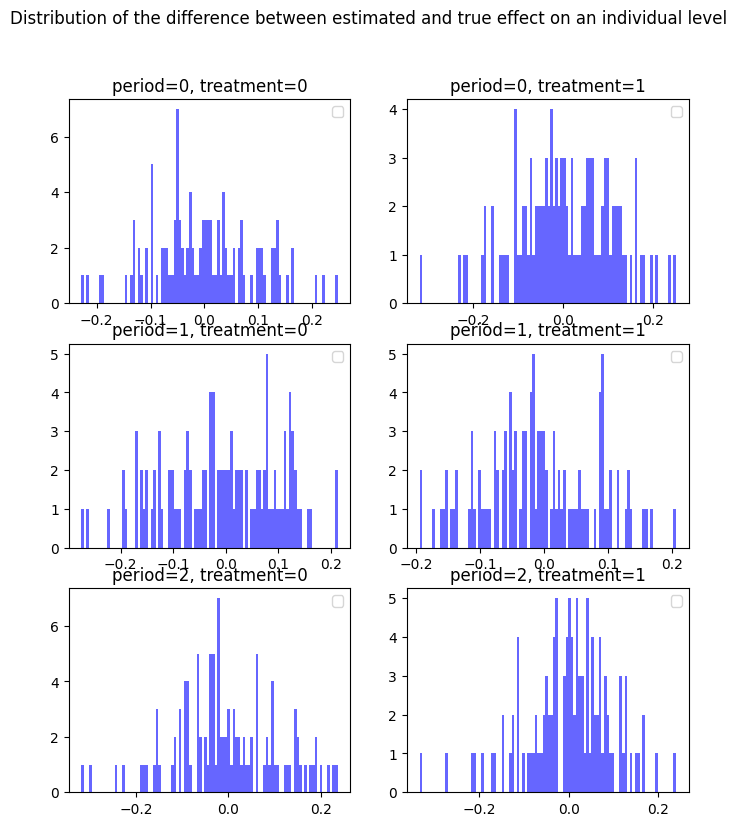

In [5]:
from src.utils import compute_gt_individual_dynamic_effects
from src.models.utils import plot_de_est_diff_distribution
individual_dynamic_effects = compute_gt_individual_dynamic_effects(args, data_pipeline, 'test')
#add random noise to ind_true_effect
import torch
ind_true_effect = torch.from_numpy(ind_true_effect + np.random.normal(0, 0.1, ind_true_effect.shape))
plot_de_est_diff_distribution(None, ind_true_effect, individual_dynamic_effects, args)

In [13]:
te2 = (ind_true_effect * np.expand_dims(np.expand_dims(T_intv_disc - T_base_disc, axis = 0), axis = 0)).sum(axis = (-1, -2))


(10, 28)

In [15]:
#compute mse between gt_te and te2 on non-nan entries
mask = np.isnan(gt_te)
mse = np.mean((gt_te[~mask] - te2[~mask]) ** 2)
print("mse between te from ind-true-effect and simulated ctf", mse)

mse between te from ind-true-effect and simulated ctf 0.0980785158313394


In [73]:
multiplier

array([[-0.5       , -0.4       ],
       [-0.35355339, -0.28284271],
       [-0.28867513, -0.23094011]])

In [ ]:
treatment = args.dataset.synth_treatments_list[0]
coeff = np.array(treatment['scale_function']['coefficients'])
print(type(coeff))
kappa = lambda x: np.tanh(np.dot(x, coeff)) + 1
print(kappa(X_dynamic[:, :, conf_vars_idx]).shape)

1.0

In [5]:
true_effects = data_pipeline.true_effect
gt_te2= (np.flip(true_effects, axis=0) * (T_intv_disc - T_base_disc)).sum()

In [7]:
gt_te2, gt_te

(-2.056011345338556,
 array([[-2.05601135, -2.05601135, -2.05601135, -2.05601135, -2.05601135,
         -2.05601135, -2.05601135, -2.05601135, -2.05601135, -2.05601135,
         -2.05601135, -2.05601135, -2.05601135, -2.05601135, -2.05601135,
         -2.05601135, -2.05601135, -2.05601135, -2.05601135, -2.05601135,
         -2.05601135, -2.05601135, -2.05601135, -2.05601135, -2.05601135,
         -2.05601135, -2.05601135, -2.05601135],
        [-2.05601135, -2.05601135, -2.05601135, -2.05601135, -2.05601135,
         -2.05601135, -2.05601135, -2.05601135, -2.05601135, -2.05601135,
         -2.05601135, -2.05601135, -2.05601135, -2.05601135, -2.05601135,
         -2.05601135, -2.05601135, -2.05601135, -2.05601135, -2.05601135,
         -2.05601135, -2.05601135,         nan,         nan,         nan,
                 nan,         nan,         nan],
        [-2.05601135, -2.05601135, -2.05601135, -2.05601135, -2.05601135,
         -2.05601135, -2.05601135, -2.05601135, -2.05601135, -2.056

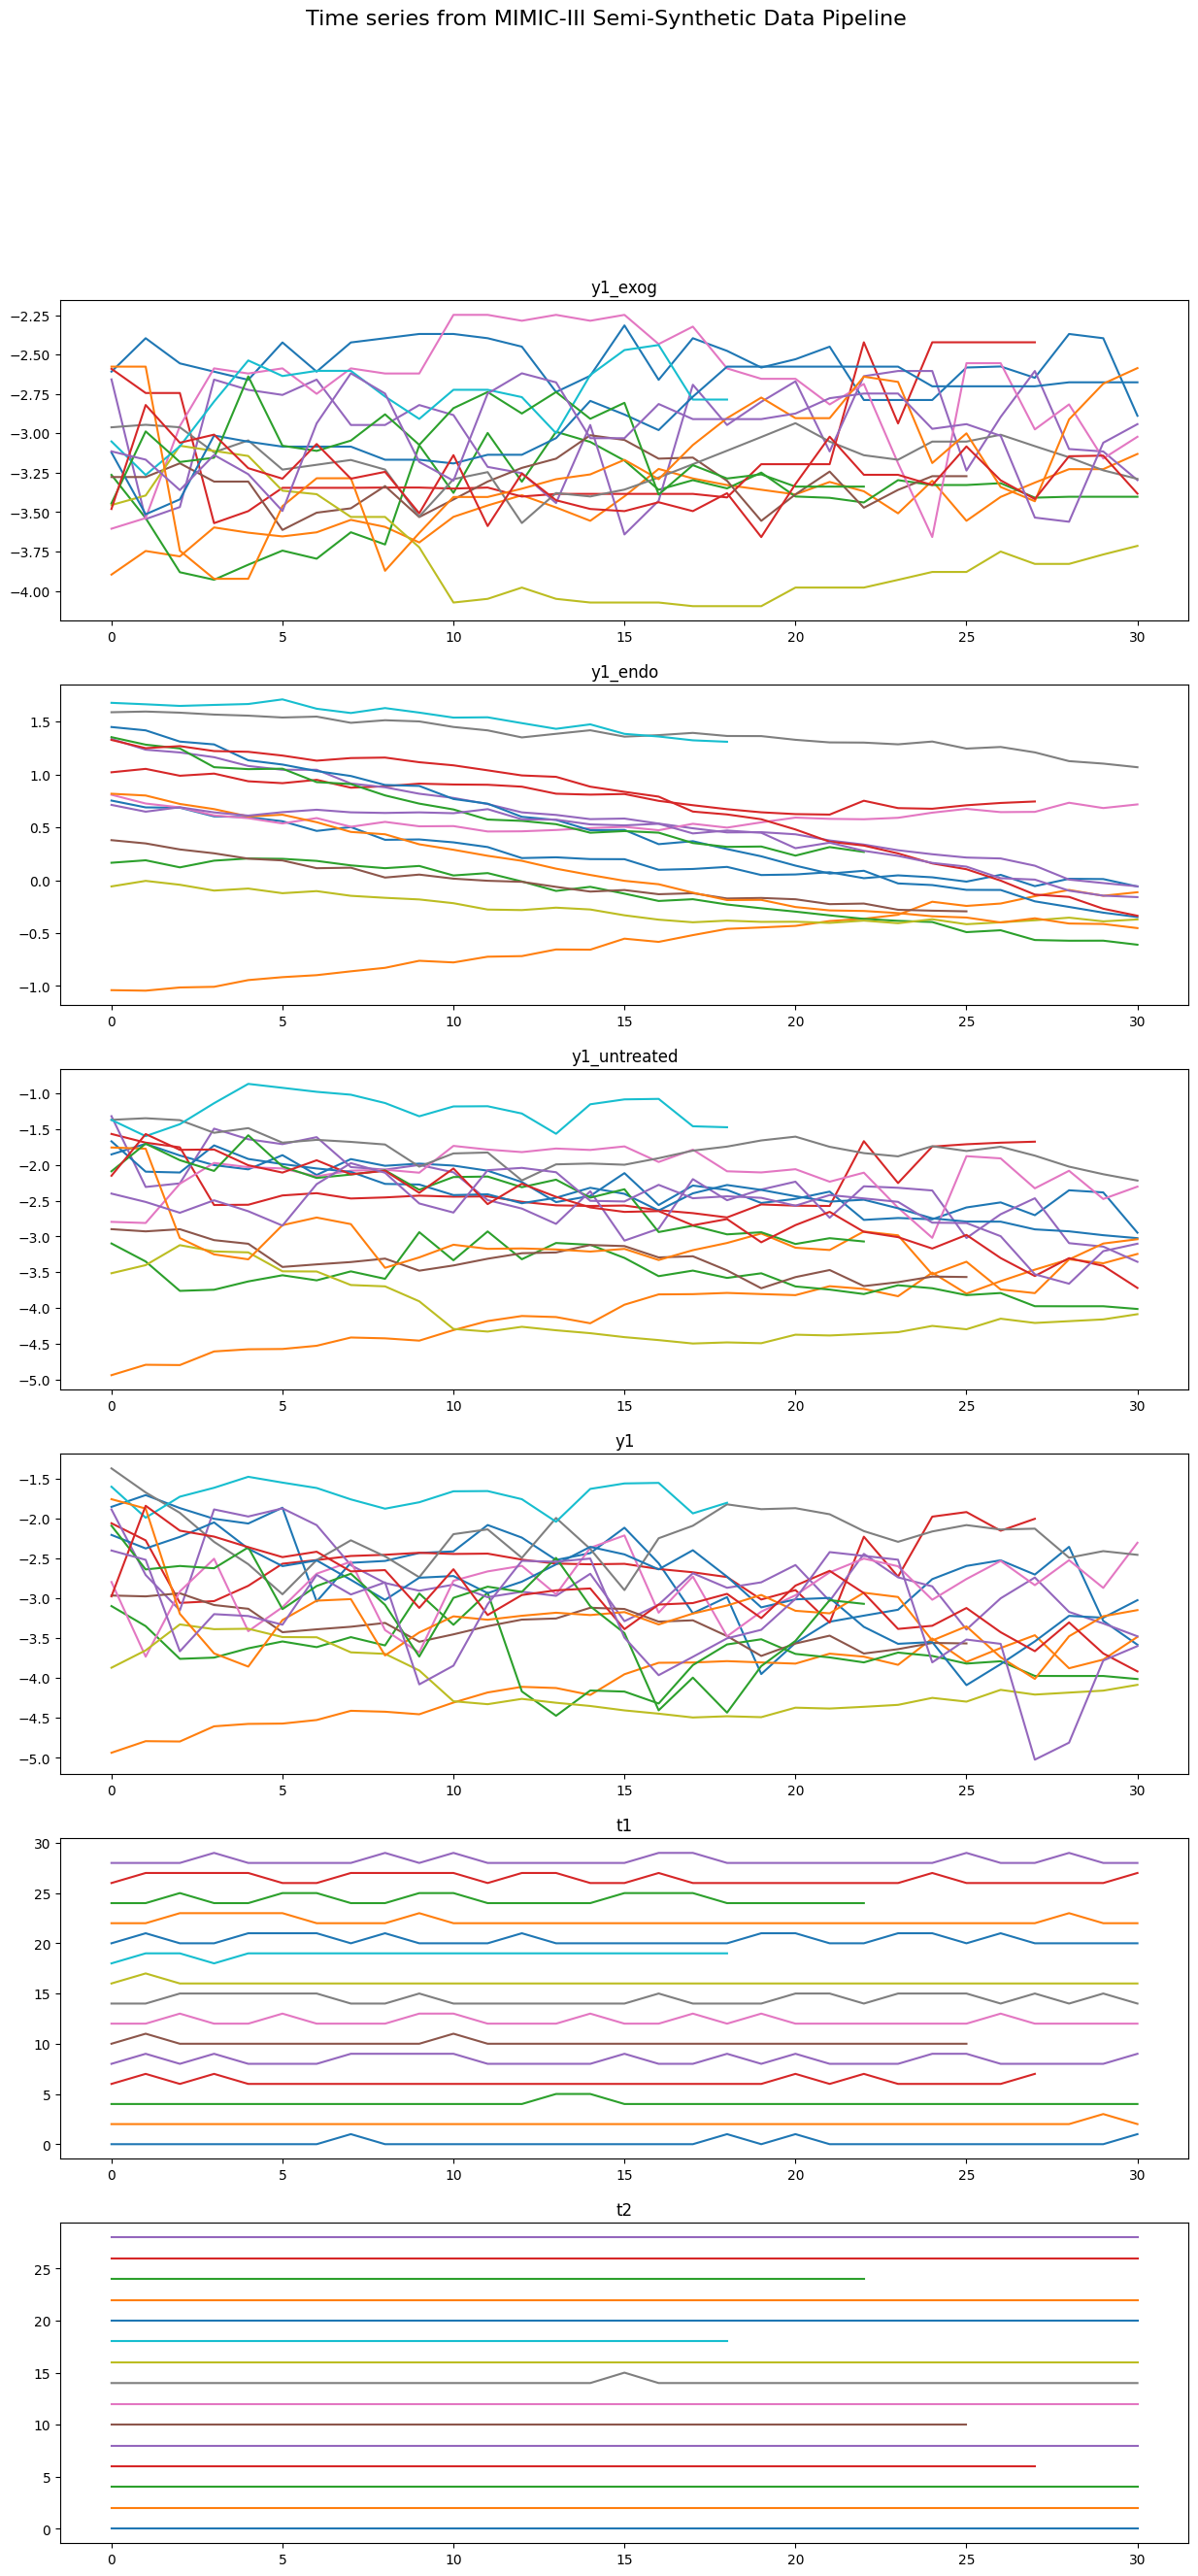

In [35]:
data_pipeline.plot_timeseries(n_patients = 15)

In [5]:
gt_te.shape

(200, 28)

In [6]:
data_pipeline

{'dataset': <src.data.mimic.semi_synthetic_pipeline.MIMICSemiSyntheticDataPipeline object at 0x000002A7D7DE34C0>, 'exp': {'exp_name': 'mimic-synthetic-debug-first-step', 'batch_size': 2, 'num_workers': 1, 'plot_residual': True}}